# 1D MT Inversion

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.colors import LogNorm
from matplotlib import cm
from matplotlib import gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy.sparse import diags

import my_functions as func

In [3]:
## DEFINIÇAO DE PARAMETROS

mu0 = 4*np.pi*1E-7 # permeabilidade magnetica
f = np.logspace(-5.0, 3.0, num=50) # vetor de frequencias (em log)
#f = np.linspace(-5.0, 3.0, num=50)
T = 1/f #periodo
omega = 2.*f*np.pi # frequencia angular
N = len(omega) # length of frequency array
z0 = 0  # The depth of the top of the first layer
im = (0.0+1.0j)

### Modelo 1

In [4]:
ptrue = (np.array([103.0, 557.0, 234., 5678.], dtype='float'))
htrue = np.ones(len(ptrue))*1000

Ztrue = func.Impedance_Tensor(omega, ptrue,htrue)

# Dado observado
Z_obs = func.multiplicative_noise(Ztrue)

rhoap_obs = (((omega*mu0)**-1.0)*(abs(Z_obs)**2))

phase = np.arctan(Z_obs.imag/Z_obs.real)
phase_obs = (phase*180)/np.pi

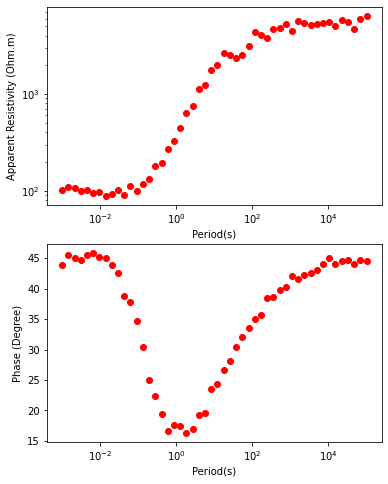

In [5]:
plt.figure(figsize=(6,8))
plt.subplot(2,1,1)
plt.plot(T,rhoap_obs,'ro')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Period(s)')
plt.ylabel('Apparent Resistivity (Ohm.m)')

plt.subplot(2,1,2)
plt.plot(T,phase_obs,'ro')
plt.xscale('log')
plt.xlabel('Period(s)')
plt.ylabel('Phase (Degree)')

plt.show()

In [6]:
#Parâmetros da inversão
mu = 1.e-12
metodo = 'suavidade'

#Parâmetros iniciais
#chute_inicial = np.array([100.0, 200.,100., 1200.])
chute_inicial = np.array([100.0, 100.,100., 100.])
h = htrue

#Calculo do problema inverso
p,deltap,phis,it_final,Z_calculado,parametros,A,jac,lamb = func.marquardt(Z_obs,chute_inicial,h,omega,mu,metodo,
                                                                     step=5, n_iteracoes=1000)

Numero de iteraçaoes 41
misfit final 0.47935149017341366
pTrue [ 103.  557.  234. 5678.]
p estimado [ 169.86134186  193.7885259   284.42787274 6116.62581791]


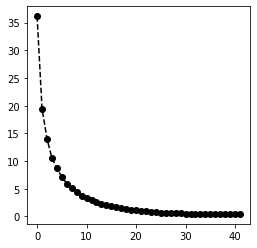

In [7]:
iteracoes = np.arange(len(phis))
print( 'Numero de iteraçaoes', it_final)
print( 'misfit final', phis[-1])
print( 'pTrue', ptrue)
print( 'p estimado', p)

plt.figure(figsize=(4,4))
plt.plot(iteracoes,phis,'--ko')
plt.show()

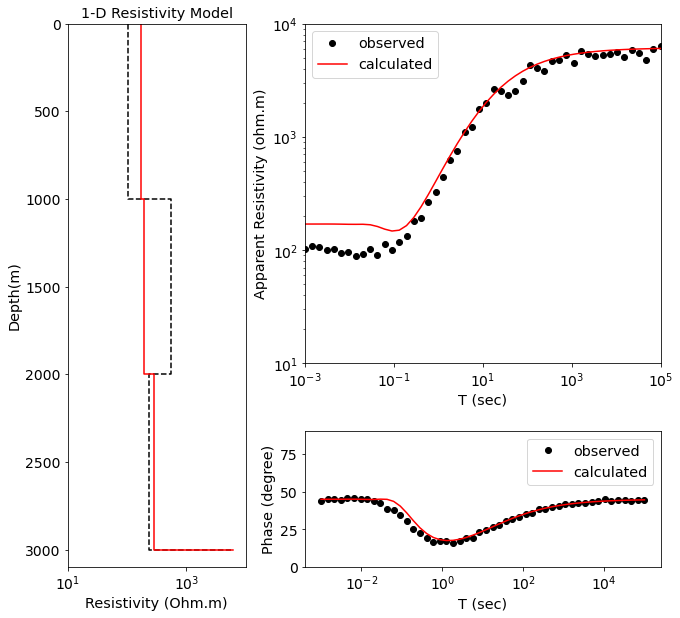

In [8]:
rhoap_calc = (((omega*mu0)**-1.0)*(abs(Z_calculado)**2))
phase = np.arctan(Z_calculado.imag/Z_calculado.real)
phi_calc = (phase*180)/np.pi

#Calculation of depths for each interface

M1 = len(ptrue)
M2 = len(chute_inicial)
interfaces1 = np.zeros(M1)
for l in range(M1):
    interfaces1[l] = z0 + sum(htrue[:l])
    
interfaces2 = np.zeros(M2)
for l in range(M2):
    interfaces2[l] = z0 + sum(h[:l])

fig = plt.figure(figsize=(14,10))
gs2 = gridspec.GridSpec(3, 3, width_ratios=[2, 4, 4])
gs2.update(left=5, right=6, hspace=0.5)

ax1 = plt.subplot(gs2[:, :-2])
ax1.step(ptrue, interfaces1, 'k--')
ax1.step(p, interfaces2, 'r')
plt.xscale('log')
ax1.set_xlabel('Resistivity (Ohm.m)',fontsize='x-large')
ax1.set_ylabel('Depth(m)',fontsize='x-large')
ax1.set_xlim((10,10000))
ax1.set_ylim((np.max(interfaces1)+100, 0))
ax1.set_title('1-D Resistivity Model',fontsize='x-large')
ax1.tick_params(labelsize=14)

ax2 = plt.subplot(gs2[:-1, -2])
ax2.plot(T, rhoap_obs,'ko', label='observed')
ax2.plot(T, rhoap_calc,'r-', label='calculated')
plt.legend(fontsize='x-large',numpoints = 1)
plt.xscale('log')
plt.yscale('log')
plt.ylim([10,10000.])
plt.xlim([np.min(T),np.max(T)])
plt.xlabel('T (sec)',fontsize='x-large')
plt.ylabel('Apparent Resistivity (ohm.m)',fontsize='x-large')
ax2.tick_params(labelsize=14)

ax3 = plt.subplot(gs2[-1, -2])
ax3.plot(T,phase_obs, 'ko', label='observed')
ax3.plot(T,phi_calc, 'r-', label='calculated')
plt.legend(fontsize='x-large',numpoints = 1)
plt.xscale('log')
plt.xlabel('T (sec)',fontsize='x-large')
plt.ylabel('Phase (degree)',fontsize='x-large')
plt.ylim([0,90])
ax3.tick_params(labelsize=14)

# Adicionando vínculo

## Chute inicial e vínculo (modelo de referência)

Os vetores h e chute_inicial e pref devem conter os mesmos números de elementos

In [9]:
#Parâmetros da inversão
mu = 1.e-7
v = 1.e-6

#Parâmetros iniciais
chute_inicial = np.array([100.0, 100.,100., 100.])
h = htrue

pref = (np.array([100.0, 400., 100., 4000.], dtype='float'))

In [10]:
#Calculo do problema inverso
p,deltap,phis,it_final,Z_calculado,parametros,A,jac,lamb = func.marquardt_vinculo(Z_obs,chute_inicial,pref,h,omega,mu,v,step=10,n_iteracoes=1000)

Numero de iteraçaoes 269
misfit final 2.409638751682556
pTrue [ 103.  557.  234. 5678.]
p estimado [ 102.4478967   214.7070758   272.85430017 4528.33222944]


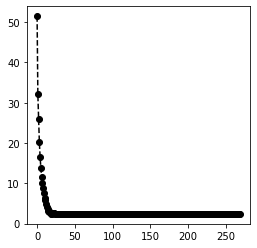

In [11]:
iteracoes = np.arange(len(phis))
print( 'Numero de iteraçaoes', it_final)
print( 'misfit final', phis[-1])
print( 'pTrue', ptrue)
print( 'p estimado', p)

plt.figure(figsize=(4,4))
plt.plot(iteracoes,phis,'--ko')
plt.show()

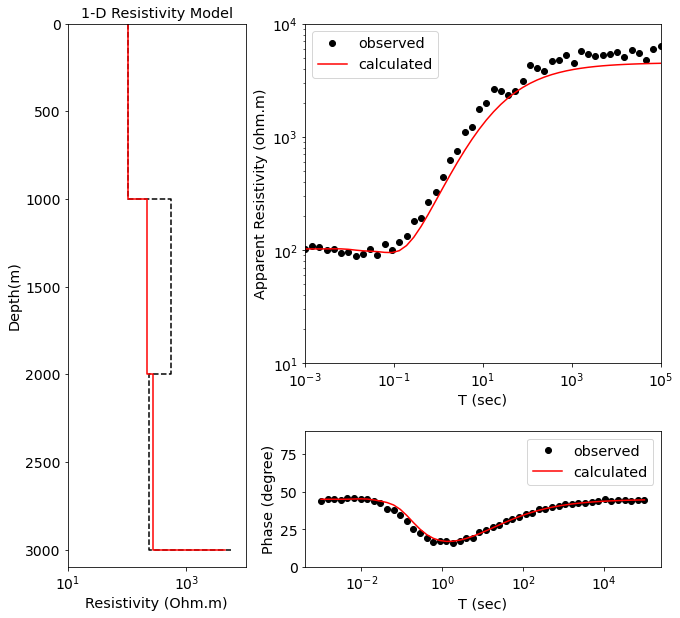

In [12]:
rhoap_calc = (((omega*mu0)**-1.0)*(abs(Z_calculado)**2))
phase = np.arctan(Z_calculado.imag/Z_calculado.real)
phi_calc = (phase*180)/np.pi

#Calculation of depths for each interface

M1 = len(ptrue)
M2 = len(chute_inicial)
interfaces1 = np.zeros(M1)
for l in range(M1):
    interfaces1[l] = z0 + sum(htrue[:l])
    
interfaces2 = np.zeros(M2)
for l in range(M2):
    interfaces2[l] = z0 + sum(h[:l])

fig = plt.figure(figsize=(14,10))
gs2 = gridspec.GridSpec(3, 3, width_ratios=[2, 4, 4])
gs2.update(left=5, right=6, hspace=0.5)

ax1 = plt.subplot(gs2[:, :-2])
ax1.step(ptrue, interfaces1, 'k--')
ax1.step(p, interfaces2, 'r')
plt.xscale('log')
ax1.set_xlabel('Resistivity (Ohm.m)',fontsize='x-large')
ax1.set_ylabel('Depth(m)',fontsize='x-large')
ax1.set_xlim((10,10000))
ax1.set_ylim((np.max(interfaces1)+100, 0))
ax1.set_title('1-D Resistivity Model',fontsize='x-large')
ax1.tick_params(labelsize=14)

ax2 = plt.subplot(gs2[:-1, -2])
ax2.plot(T, rhoap_obs,'ko', label='observed')
ax2.plot(T, rhoap_calc,'r-', label='calculated')
plt.legend(fontsize='x-large',numpoints = 1)
plt.xscale('log')
plt.yscale('log')
plt.ylim([10,10000.])
plt.xlim([np.min(T),np.max(T)])
plt.xlabel('T (sec)',fontsize='x-large')
plt.ylabel('Apparent Resistivity (ohm.m)',fontsize='x-large')
ax2.tick_params(labelsize=14)

ax3 = plt.subplot(gs2[-1, -2])
ax3.plot(T,phase_obs, 'ko', label='observed')
ax3.plot(T,phi_calc, 'r-', label='calculated')
plt.legend(fontsize='x-large',numpoints = 1)
plt.xscale('log')
plt.xlabel('T (sec)',fontsize='x-large')
plt.ylabel('Phase (degree)',fontsize='x-large')
plt.ylim([0,90])
ax3.tick_params(labelsize=14)

### Modelo 2

In [13]:
ptrue = np.array([104.0,532.0,1234.0,5682.0,10407.0])
htrue = np.array([1000.0, 2000.0, 1000.0, 5000.0, 1000.])

Ztrue = func.Impedance_Tensor(omega, ptrue,htrue)

# Dado observado
Z_obs = func.multiplicative_noise(Ztrue)

rhoap_obs = (((omega*mu0)**-1.0)*(abs(Z_obs)**2))
phase = np.arctan(Z_obs.imag/Z_obs.real)
phase_obs = (phase*180)/np.pi

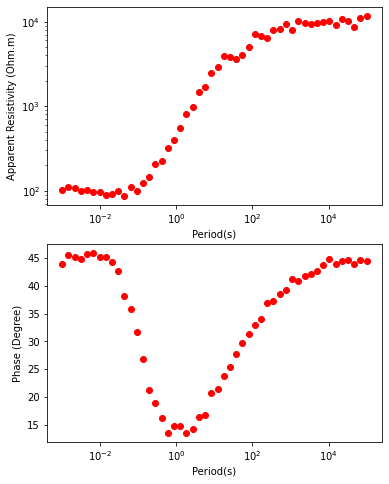

In [14]:
plt.figure(figsize=(6,8))
plt.subplot(2,1,1)
plt.plot(T,rhoap_obs,'ro')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Period(s)')
plt.ylabel('Apparent Resistivity (Ohm.m)')

plt.subplot(2,1,2)
plt.plot(T,phase_obs,'ro')
plt.xscale('log')
plt.xlabel('Period(s)')
plt.ylabel('Phase (Degree)')

plt.show()

In [15]:
#Parâmetros da inversão
mu = 1.e-10
metodo = 'suavidade'

#Parâmetros iniciais
chute_inicial = np.ones(10)*100
chute_inicial[5:] = 2000
h = np.ones(10)*1000


#Calculo do problema inverso
p,deltap,phis,it_final,Z_calculado,parametros,A,jac,lamb = func.marquardt(Z_obs,chute_inicial,h,omega,mu,metodo,
                                                                     step=5, n_iteracoes=1000)

Numero de iteraçaoes 104
misfit final 0.48821454558042876
pTrue [  104.   532.  1234.  5682. 10407.]
p estimado [ 137.6143754   589.83284693  680.23029635 1165.21540635  707.79509997
 5573.27879061 7985.28304402 8935.33595509 8449.09633034 7635.04529366]


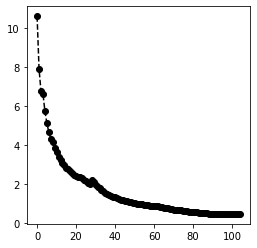

In [16]:
iteracoes = np.arange(len(phis))
print( 'Numero de iteraçaoes', it_final)
print( 'misfit final', phis[-1])
print( 'pTrue', ptrue)
print( 'p estimado', p)
plt.figure(figsize=(4,4))
plt.plot(iteracoes,phis,'--ko')
plt.show()

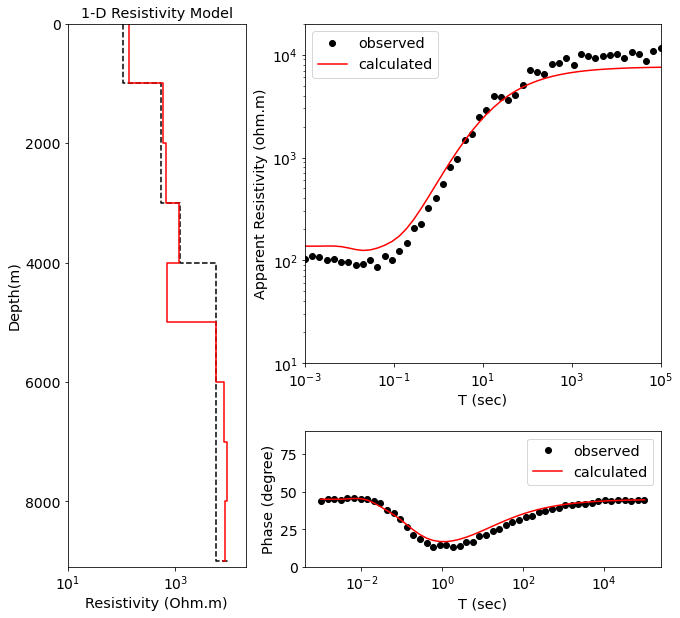

In [17]:
#Calculation of depths for each interface

rhoap_calc = (((omega*mu0)**-1.0)*(abs(Z_calculado)**2))
phase = np.arctan(Z_calculado.imag/Z_calculado.real)
phi_calc = (phase*180)/np.pi

M1 = len(ptrue)
M2 = len(chute_inicial)
z0 = 0
interfaces1 = np.zeros(M1)
for l in range(M1):
    interfaces1[l] = z0 + sum(htrue[:l])
    
interfaces2 = np.zeros(M2)
for l in range(M2):
    interfaces2[l] = z0 + sum(h[:l])

fig = plt.figure(figsize=(14,10))
gs2 = gridspec.GridSpec(3, 3, width_ratios=[2, 4, 4])
gs2.update(left=5, right=6, hspace=0.5)

ax1 = plt.subplot(gs2[:, :-2])
ax1.step(ptrue, interfaces1, 'k--')
ax1.step(p, interfaces2, 'r')
plt.xscale('log')
ax1.set_xlabel('Resistivity (Ohm.m)',fontsize='x-large')
ax1.set_ylabel('Depth(m)',fontsize='x-large')
ax1.set_xlim((10,20000))
ax1.set_ylim((np.max(interfaces1)+100, 0))
ax1.set_title('1-D Resistivity Model',fontsize='x-large')
ax1.tick_params(labelsize=14)

ax2 = plt.subplot(gs2[:-1, -2])
ax2.plot(T, rhoap_obs,'ko', label='observed')
ax2.plot(T, rhoap_calc,'r-', label='calculated')
plt.legend(fontsize='x-large',numpoints = 1)
plt.xscale('log')
plt.yscale('log')
plt.ylim([10,20000.])
plt.xlim([np.min(T),np.max(T)])
plt.xlabel('T (sec)',fontsize='x-large')
plt.ylabel('Apparent Resistivity (ohm.m)',fontsize='x-large')
ax2.tick_params(labelsize=14)

ax3 = plt.subplot(gs2[-1, -2])
ax3.plot(T,phase_obs, 'ko', label='observed')
ax3.plot(T,phi_calc, 'r-', label='calculated')
plt.legend(fontsize='x-large',numpoints = 1)
plt.xscale('log')
plt.xlabel('T (sec)',fontsize='x-large')
plt.ylabel('Phase (degree)',fontsize='x-large')
plt.ylim([0,90])
ax3.tick_params(labelsize=14)

## Chute inicial e vínculo (modelo de referência)

Os vetores h e chute_inicial e pref devem conter os mesmos números de elementos

In [18]:
#Parâmetros da inversão
mu = 1.e-10
v = 1.e-10

#Parâmetros iniciais
chute_inicial = np.ones(10)*50
chute_inicial[5:] = 1000
h = np.ones(10)*1000

pref = (np.array([100.0, 100., 500., 500., 1000., 1500., 4000., 4000., 6000., 5000], dtype='float'))

In [19]:
#Calculo do problema inverso
p,deltap,phis,it_final,Z_calculado,parametros,A,jac,lamb = func.marquardt_vinculo(Z_obs,chute_inicial,pref,h,omega,mu,v,step=10,n_iteracoes=1000)

Numero de iteraçaoes 70
misfit final 0.7840600714050003
pTrue [  104.   532.  1234.  5682. 10407.]
p estimado [ 165.6495152   360.94883128  710.36517131 1504.20859389 5965.02443424
  456.59753488 5562.67767311 6416.21338526 6975.6048828  7732.62218257]


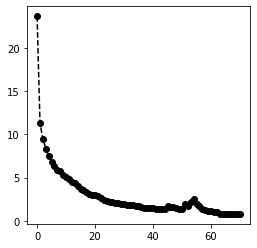

In [20]:
iteracoes = np.arange(len(phis))
print( 'Numero de iteraçaoes', it_final)
print( 'misfit final', phis[-1])
print( 'pTrue', ptrue)
print( 'p estimado', p)

plt.figure(figsize=(4,4))
plt.plot(iteracoes,phis,'--ko')
plt.show()

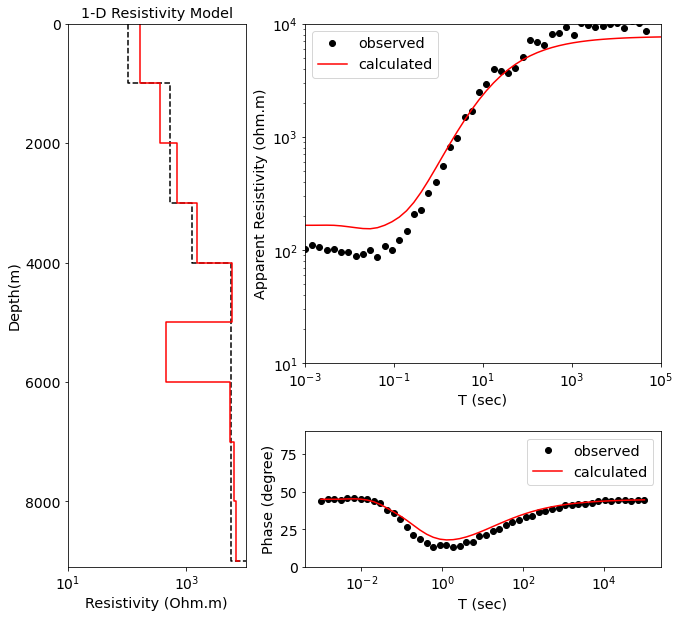

In [21]:
rhoap_calc = (((omega*mu0)**-1.0)*(abs(Z_calculado)**2))
phase = np.arctan(Z_calculado.imag/Z_calculado.real)
phi_calc = (phase*180)/np.pi

#Calculation of depths for each interface

M1 = len(ptrue)
M2 = len(chute_inicial)
interfaces1 = np.zeros(M1)
for l in range(M1):
    interfaces1[l] = z0 + sum(htrue[:l])
    
interfaces2 = np.zeros(M2)
for l in range(M2):
    interfaces2[l] = z0 + sum(h[:l])

fig = plt.figure(figsize=(14,10))
gs2 = gridspec.GridSpec(3, 3, width_ratios=[2, 4, 4])
gs2.update(left=5, right=6, hspace=0.5)

ax1 = plt.subplot(gs2[:, :-2])
ax1.step(ptrue, interfaces1, 'k--')
ax1.step(p, interfaces2, 'r')
plt.xscale('log')
ax1.set_xlabel('Resistivity (Ohm.m)',fontsize='x-large')
ax1.set_ylabel('Depth(m)',fontsize='x-large')
ax1.set_xlim((10,10000))
ax1.set_ylim((np.max(interfaces1)+100, 0))
ax1.set_title('1-D Resistivity Model',fontsize='x-large')
ax1.tick_params(labelsize=14)

ax2 = plt.subplot(gs2[:-1, -2])
ax2.plot(T, rhoap_obs,'ko', label='observed')
ax2.plot(T, rhoap_calc,'r-', label='calculated')
plt.legend(fontsize='x-large',numpoints = 1)
plt.xscale('log')
plt.yscale('log')
plt.ylim([10,10000.])
plt.xlim([np.min(T),np.max(T)])
plt.xlabel('T (sec)',fontsize='x-large')
plt.ylabel('Apparent Resistivity (ohm.m)',fontsize='x-large')
ax2.tick_params(labelsize=14)

ax3 = plt.subplot(gs2[-1, -2])
ax3.plot(T,phase_obs, 'ko', label='observed')
ax3.plot(T,phi_calc, 'r-', label='calculated')
plt.legend(fontsize='x-large',numpoints = 1)
plt.xscale('log')
plt.xlabel('T (sec)',fontsize='x-large')
plt.ylabel('Phase (degree)',fontsize='x-large')
plt.ylim([0,90])
ax3.tick_params(labelsize=14)